In [14]:
import numpy as np
import pandas as pd
import analysis.data_preprocessing
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Helper Function

In [15]:
def standardize(data):
    mean_per_column = data.mean(axis=0, numeric_only=True)
    std_per_column = data.std(axis=0, numeric_only=True)
    return (data - mean_per_column)/std_per_column

# Data collection and preprocessing

In [16]:
NSES = analysis.data_preprocessing.get_NSES()
data = analysis.data_preprocessing.get_full_data()
data = pd.merge(data, NSES, on='NAME')
data_model = data.drop(['GEO_ID','NAME','AMERICAN_INDIAN_ALASKA_NATIVE','NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER','SERVICE',
                  'SALES AND OFFICE','NATURAL RESOURCES, CONSTRUCTION, MAINTENANCE','PRODUCTION, TRANSPORTATION, MATERIAL MOVING',
                  'LESS_HIGH_SCHOOL','HIGH_SCHOOL_GRADUATE','ASIAN','HISPANIC_LATINO',
                  'AFRICAN_AMERICAN','WHITE','MANAGEMENT, BUSINESS, SCIENCE, ARTS'], axis = 1).dropna()
data_model[['UNEMPLOYMENT_RATE', 'PERCENTAGE_INSURED', 'RATIO_BLACK_TO_WHITE','DEGREE_HOLDERS','MEDIAN_HOUSEHOLD_INCOME',
            'TOTAL_POPULATION','MEDIAN_AGE','MALE','TREND']] = standardize(data_model[['UNEMPLOYMENT_RATE', 'PERCENTAGE_INSURED',
                                                                               'RATIO_BLACK_TO_WHITE','DEGREE_HOLDERS',
                                                                               'MEDIAN_HOUSEHOLD_INCOME','TOTAL_POPULATION',
                                                                               'MEDIAN_AGE','MALE','TREND']])

data_model['CASES'] = np.log10(data_model['CASES'])
labels_final = {'MEDIAN_HOUSEHOLD_INCOME':'income', 'DEGREE_HOLDERS':'degree holders', 'UNEMPLOYMENT_RATE':'unemployment',
                'PERCENTAGE_INSURED':'insurance','VADER_SCORE':'VADER','TOTAL_POPULATION':'population','MALE':'male',
                'MEDIAN_AGE':'age','CASES':'COVID-19 cases','RATIO_BLACK_TO_WHITE':'ratio black white','NSES':'NSES'}
data_model = data_model.rename(columns=labels_final)

# Check Linear Regression Assumptions

### 1. Linear relationship - Scatter plot

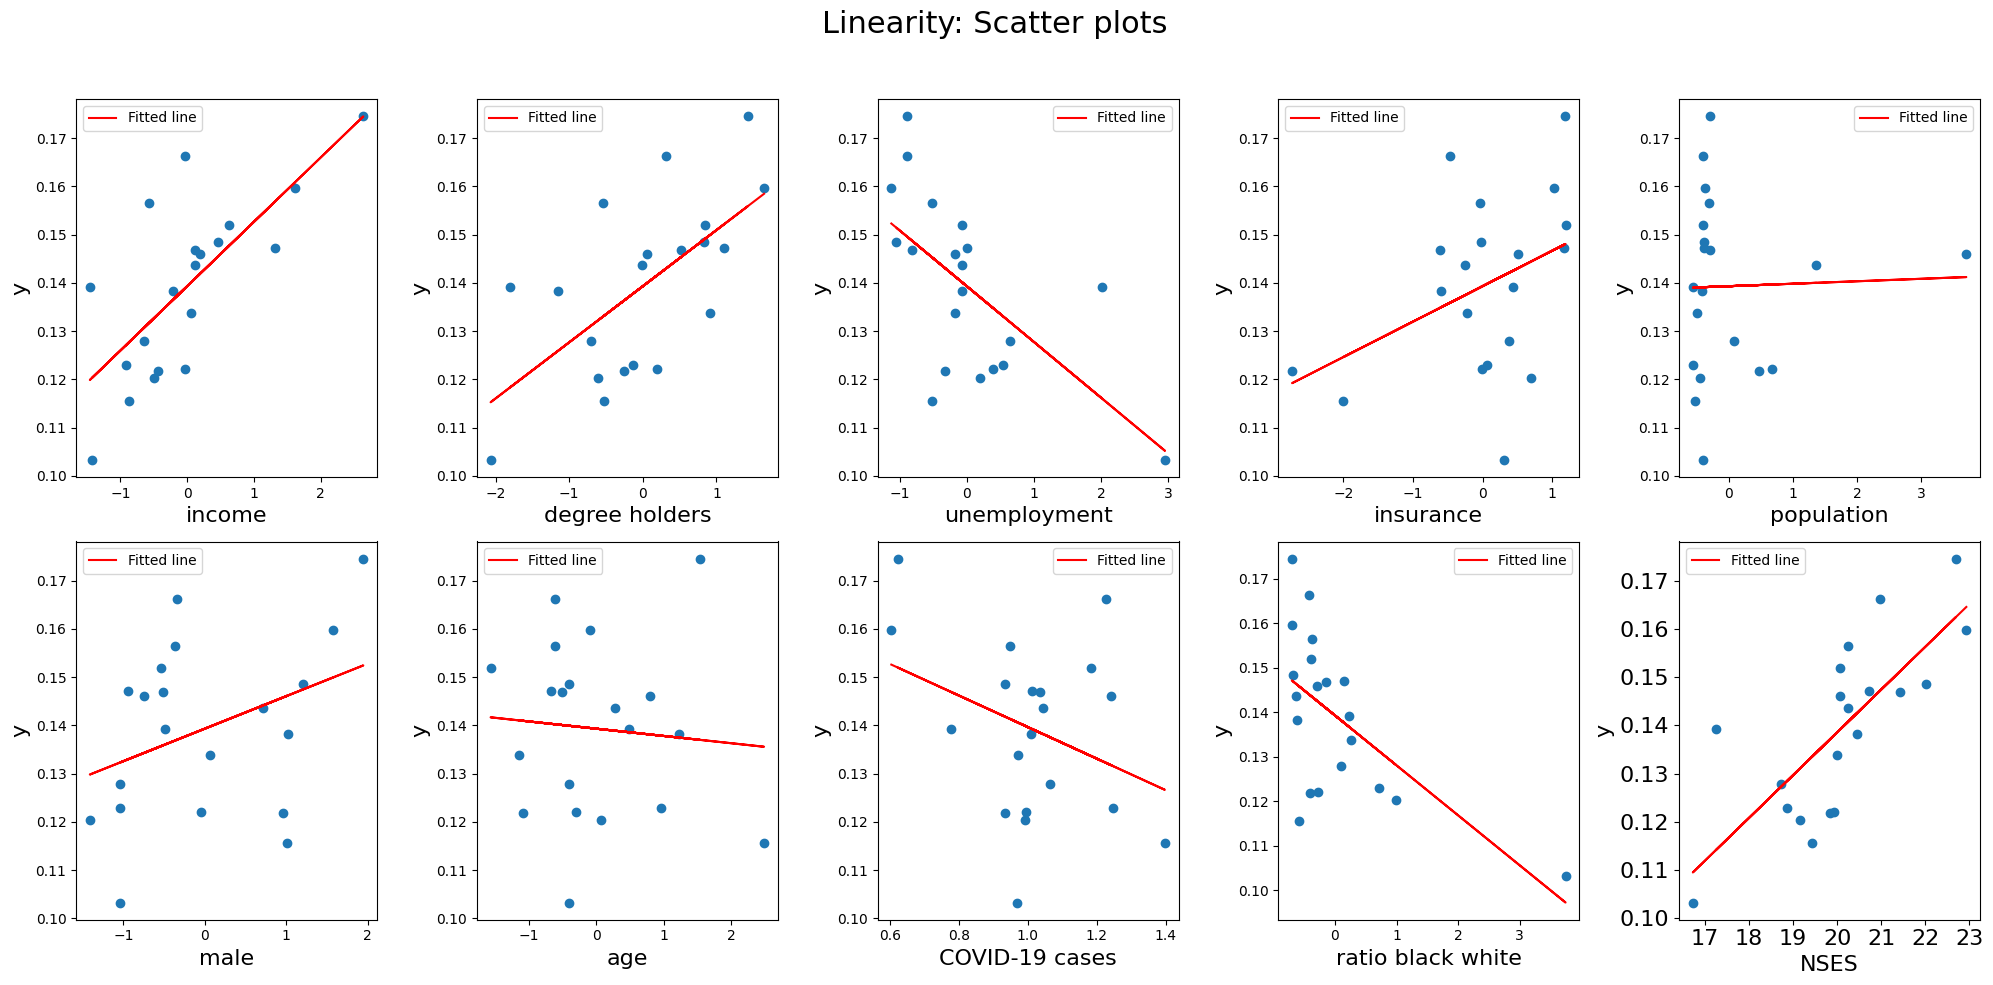

In [17]:
features = data_model.drop(['VADER','TREND'],axis=1)
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()
for i, feature in enumerate(features.columns):
    X = sm.add_constant(data_model[feature])
    model = sm.OLS(data_model['VADER'], X)
    results = model.fit()
    axs[i].scatter(data_model[feature], data_model['VADER'])
    axs[i].plot(data_model[feature], results.predict(), color='red', label='Fitted line')
    axs[i].set_xlabel(feature,fontsize=16)
    axs[i].set_ylabel('y',fontsize=16)
    axs[i].legend()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.suptitle('Linearity: Scatter plots',fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('linearity.png')
plt.show()
plt.show()

### 2. Independence - Durbin-Watson test

In [18]:
dw_results = []
for i, feature in enumerate(features.columns):
    X = sm.add_constant(data_model[feature])
    model = sm.OLS(data_model['VADER'], X)
    results = model.fit()
    dw_test = sm.stats.stattools.durbin_watson(results.resid)
    print(f"Durbin-Watson test statistic: {dw_test}")
    dw_results.append(dw_test)
dw_df = pd.DataFrame({'Feature': features.columns, 'Durbin-Watson': dw_results})
print(dw_df)

Durbin-Watson test statistic: 2.4273652634136758
Durbin-Watson test statistic: 2.2389408464924334
Durbin-Watson test statistic: 2.4820858738978804
Durbin-Watson test statistic: 2.0795117851466594
Durbin-Watson test statistic: 2.4091802560279496
Durbin-Watson test statistic: 2.6959630340376624
Durbin-Watson test statistic: 2.3426700247285828
Durbin-Watson test statistic: 2.6429495110238768
Durbin-Watson test statistic: 2.7474561417020635
Durbin-Watson test statistic: 2.5574687580048234
             Feature  Durbin-Watson
0             income       2.427365
1     degree holders       2.238941
2       unemployment       2.482086
3          insurance       2.079512
4         population       2.409180
5               male       2.695963
6                age       2.342670
7     COVID-19 cases       2.642950
8  ratio black white       2.747456
9               NSES       2.557469


### 3. Homoscedasticity - Residual plot

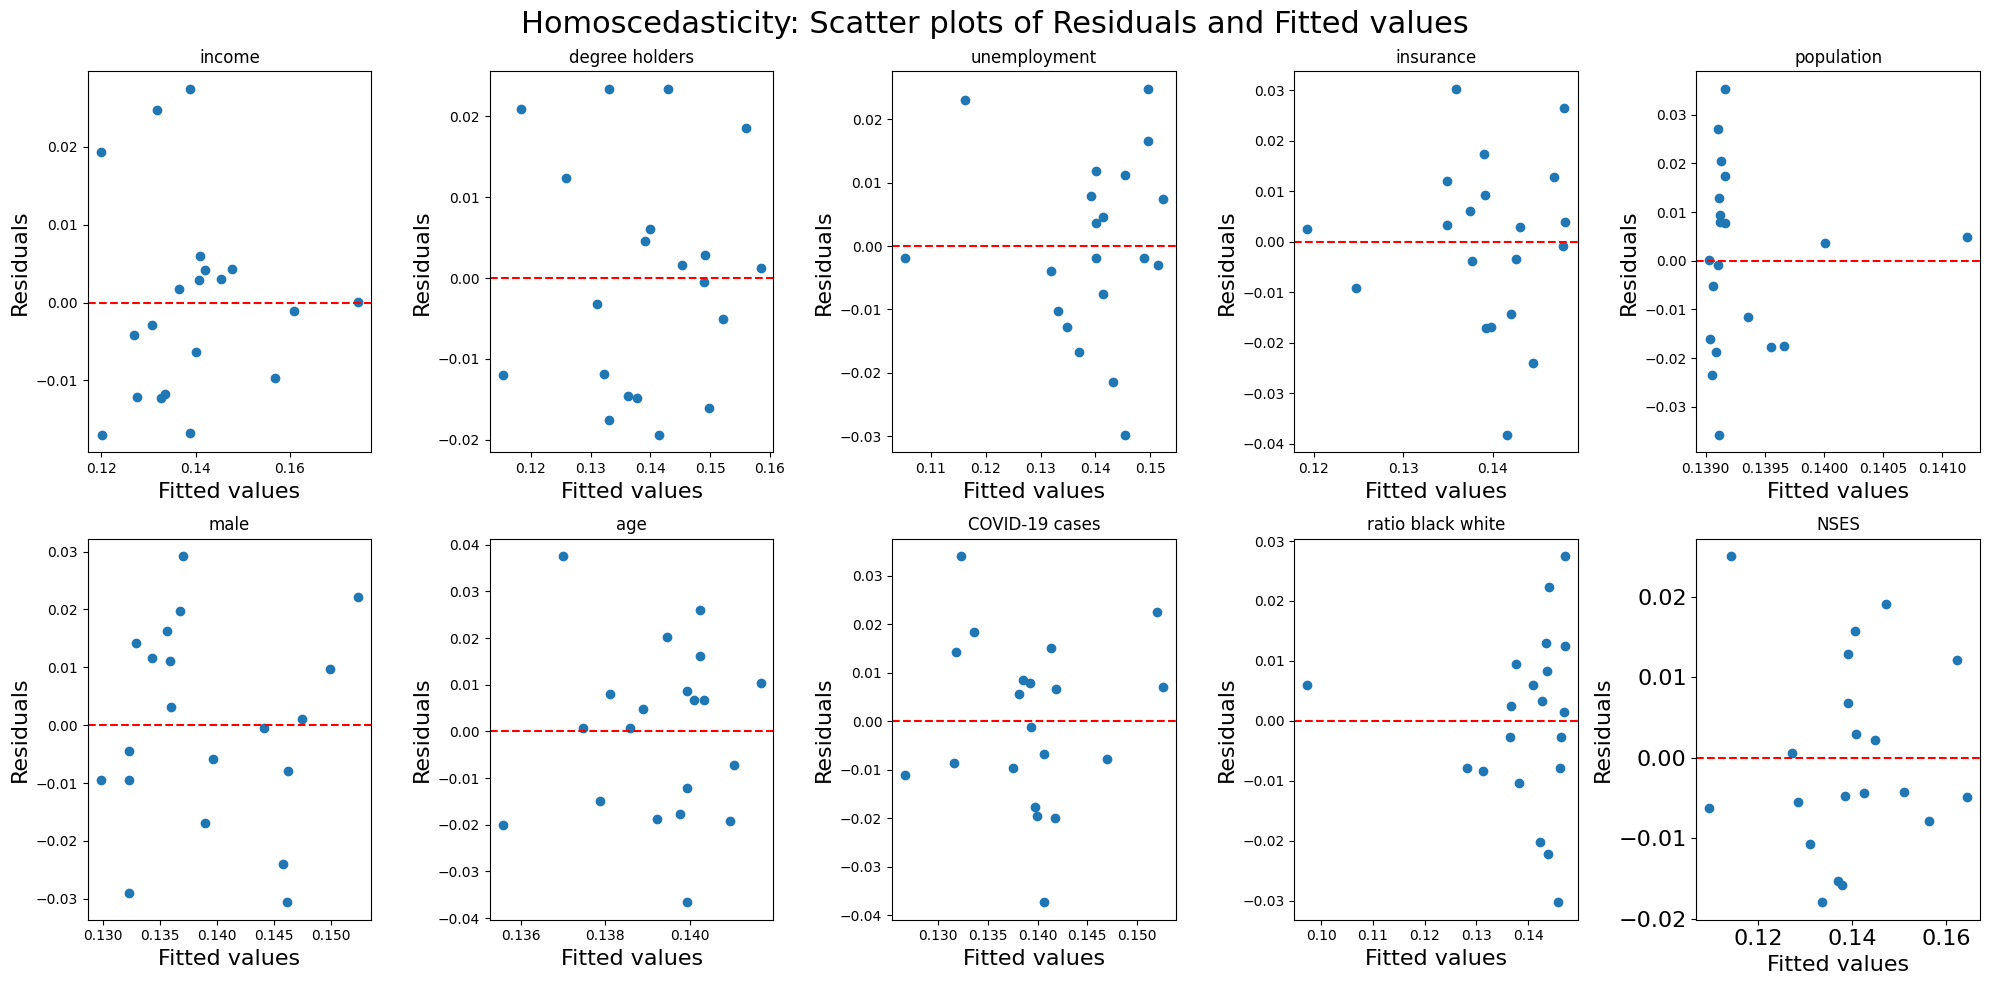

In [19]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()
for i, feature in enumerate(features.columns):
    X = sm.add_constant(data_model[feature])
    model = sm.OLS(data_model['VADER'], X)
    results = model.fit()
    axs[i].scatter(results.predict(), results.resid)
    axs[i].set_xlabel('Fitted values',fontsize=16)
    axs[i].set_ylabel('Residuals',fontsize=16)
    axs[i].set_title(feature)
    axs[i].axhline(y=0, color='red', linestyle='--')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.suptitle('Homoscedasticity: Scatter plots of Residuals and Fitted values',fontsize=22)
plt.tight_layout()
plt.savefig('homoscedasticity.png')
plt.show()

### 4. Normality - QQ plot

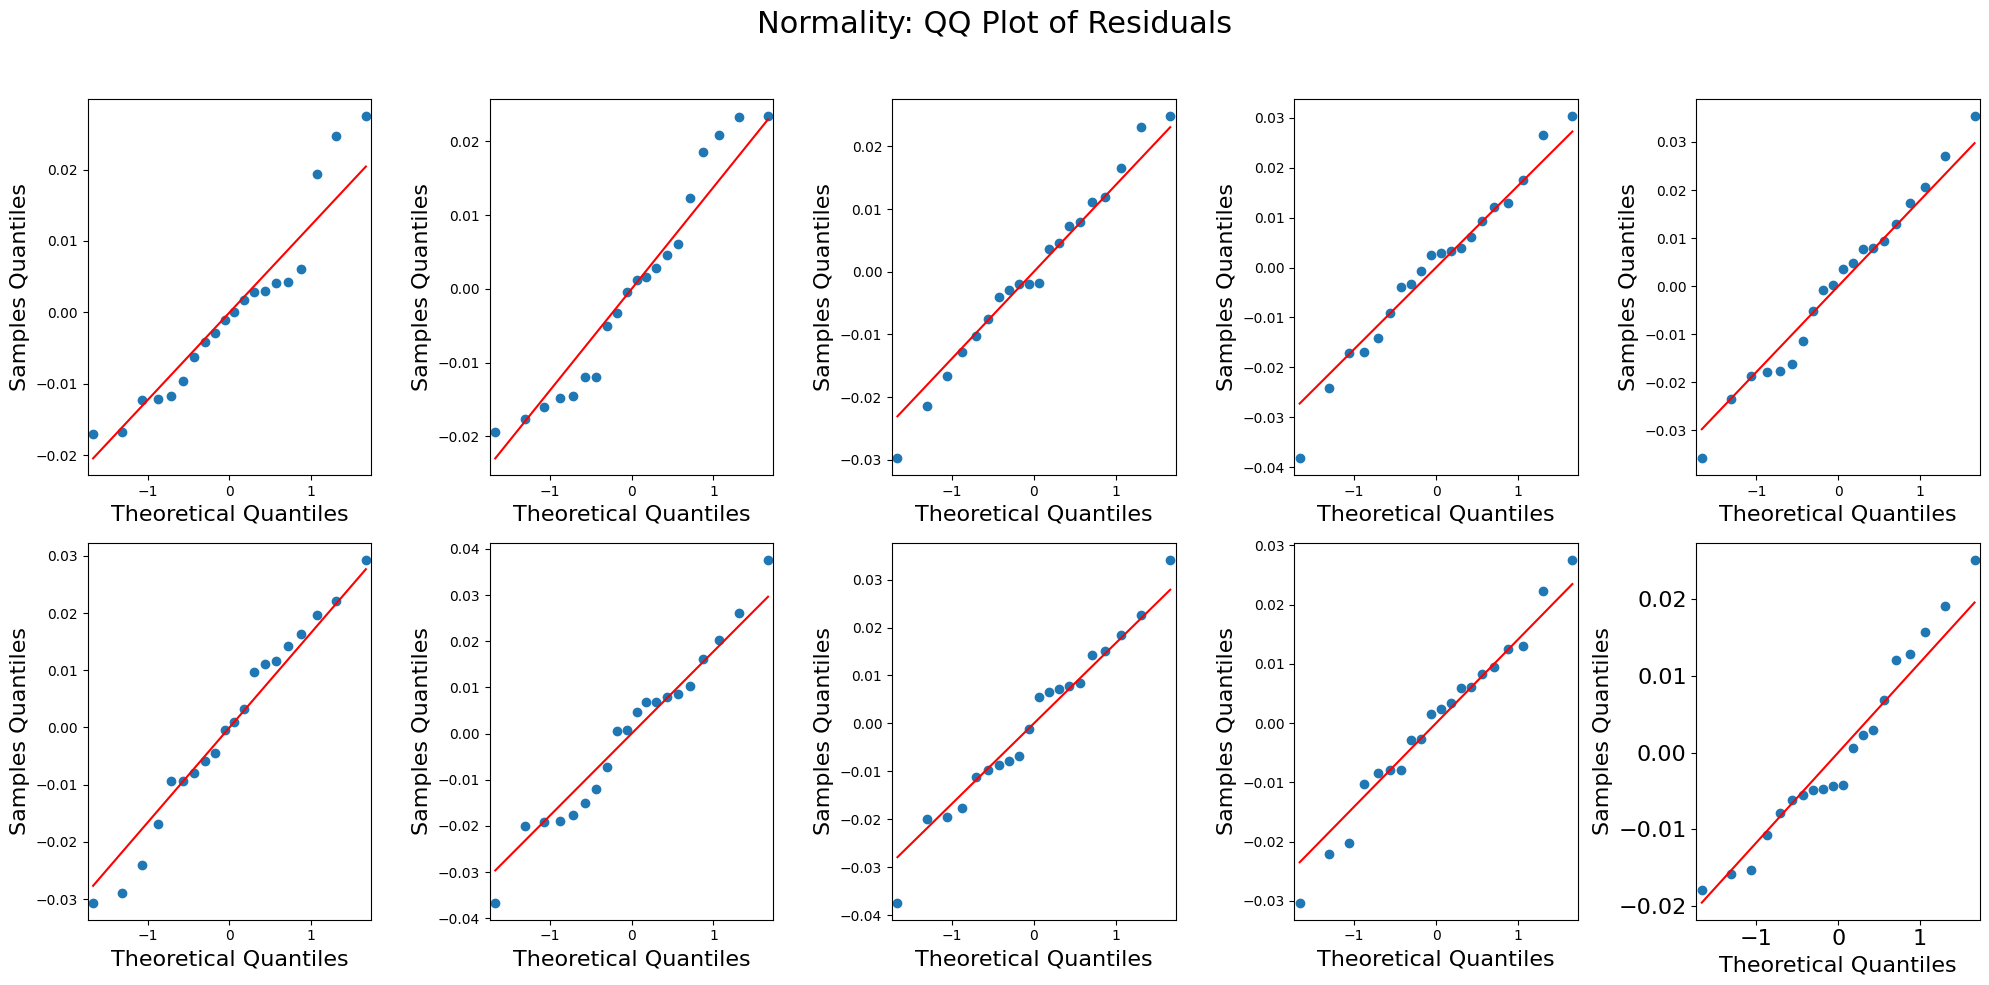

In [20]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()
for i, feature in enumerate(features.columns):
    X = sm.add_constant(data_model[feature])  # Add constant term to the independent variable
    model = sm.OLS(data_model['VADER'], X)
    results = model.fit()
    ax = axs[i]
    sm.qqplot(results.resid, line='s', ax=ax)
    ax.set_xlabel('Theoretical Quantiles', fontsize=16)
    ax.set_ylabel('Samples Quantiles', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.suptitle('Normality: QQ Plot of Residuals',fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('qqplots.png')
plt.show()

### 5. Multicollinearity - Correlation matrix

In [21]:
for i, feature in enumerate(features.columns):
    X = sm.add_constant(data_model[feature])
    model = sm.OLS(data_model['VADER'], X)
    results = model.fit()
    corr_matrix = data_model.drop(columns=['VADER']).corr()
    corr_with_feature = corr_matrix[feature].drop(feature)
    if (corr_with_feature.abs() > 0.7).any():
        correlated_features = corr_with_feature[corr_with_feature.abs() > 0.7].index.tolist()
        print(f"Correlation: The feature '{feature}' is highly correlated with the following features:")
        print(correlated_features)
    else:
        print(f"Correlation: The feature '{feature}' is not highly correlated with any other features.")


Correlation: The feature 'income' is highly correlated with the following features:
['degree holders', 'NSES']
Correlation: The feature 'degree holders' is highly correlated with the following features:
['income', 'unemployment', 'NSES']
Correlation: The feature 'unemployment' is highly correlated with the following features:
['degree holders', 'ratio black white', 'NSES']
Correlation: The feature 'insurance' is not highly correlated with any other features.
Correlation: The feature 'population' is not highly correlated with any other features.
Correlation: The feature 'male' is not highly correlated with any other features.
Correlation: The feature 'age' is not highly correlated with any other features.
Correlation: The feature 'COVID-19 cases' is not highly correlated with any other features.
Correlation: The feature 'ratio black white' is highly correlated with the following features:
['unemployment']
Correlation: The feature 'NSES' is highly correlated with the following features:
